Packages

In [1]:
import pathlib
from pathlib import Path
import os 

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import cmocean as cmo
import scipy
from scipy import stats
import netCDF4
from netCDF4 import Dataset as nc
import cartopy.crs as ccrs
import matplotlib
import seaborn as sns

from AirSeaFluxCode import AirSeaFluxCode

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
import math

font = {'weight' : 'normal',
        'size'  : 20}
matplotlib.rc('font', **font)

Functions

In [2]:
import math
def wind_sp_kt_to_ms(wind_kts):
    
    return wind_kts*0.514444  #kt to m/s

def wind_sp_to_10m(wind_sp, z0=1.52e-4, zm=3.4, z10=10):
    
    """Correct wind speed data from a given height to 10m above sea level.

       wind_sp = wind speed measurement (m/s)
       z0      = roughness length
       zm      = height of wind measurement
       z10     = height to correct to
    """
    
    return wind_sp*(math.log(z10/z0)/math.log(zm/z0))

def wind_direction(v, u):
    DIR=90-np.rad2deg(np.arctan(v / u) )
    return DIR

from tqdm import tqdm  # Assuming you're using the tqdm library for progress tracking

def colocate_era5_sd(sd, era5, var):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.
    - var (str): The variable to be colocated.

    Returns:
    - era5_var (numpy.ndarray): An array of ERA5 variable values colocated with SD.
    """

    # Initialize an empty array to store ERA5 variable values
    era5_var = np.ndarray(sd.time.size)

    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        era5_var[t] = era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)[var].data

    return era5_var

def era5dewtorh(era5_ds):
    # Extract dew point temperature (Dp) values from the input dataset
    Dp = era5_ds.d2m.values-273.15 # dew point temperature in celsius

    # Extract air temperature (T) values from the input dataset, and convert to celsius
    T = era5_ds.t2m.values # temperature in celsius
    
    # Calculate relative humidity (RH) using the formula and add it to the input dataset
    era5_ds['rh'] = (('time', 'latitude', 'longitude'),
                     100 * (np.exp((17.625 * Dp) / (243.04 + Dp)) / np.exp((17.625 * T) / (243.04 + T))))
    
    # Return the input dataset with the 'rh' variable added
    return era5_ds

def dist_era5_sd(sd, era5):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.

    Returns:
    - dist (numpy.ndarray): An array of distance in meters between nearest ERA5 gridpoint and SD.
    """

    # Initialize an empty array to store ERA5 variable values
    dist = np.ndarray(sd.time.size)
    #time = np.ndarray(sd.time.size)
    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        dist[t] = gsw.distance([era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['longitude'].data, sd.longitude[t]],[era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['latitude'].data, sd.latitude[t]]) 
        
        #dist[t]= (((era5.latitude[lat_idx]-sd.latitude[lat_idx])**2)+((era5.longitude[lon_idx]-sd.longitude[lon_idx])**2))**0.5
        #time[t] = era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['time']
        
        
    return dist

Load datasets

In [3]:
ds=xr.open_dataset( pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ds.nc')
ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ERA5file.nc')
coloc3=pd.read_csv(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/coloc3.csv') #open coloc3
dsadcpH=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/dsadcpH.nc')
ostia=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ostia.nc')

Load variables

In [4]:
hum1=dsadcpH.rh.values

spd= coloc3.abs_rel.values#relative windpeed
SST= dsadcpH.sst.values
T= dsadcpH.t2m.values #seasurface temperature in kelvin. Will convert iff less than 200
hum= ['rh', hum1 ] #chose rh, spec hum or dew point temp.
P= dsadcpH.P_SEA.values #air pressure in hPA
SST_fl ='bulk' #string, 'bulk' or 'skin' for input
meth= 'C35' #string, choose method of calcultion
lat= dsadcpH.latitude.values #latitude
hin=([10, 2.3, 2.3])  #sensor heights in m, 3x1 same order as output 
hout=10 #output height, default is 10m
Rl=dsadcpH.dwlw.values#longwave dwn radiation
Rs= dsadcpH.dwsw.values # shortwave dwn radiation
cskin= 1 #0 cool skin adj off
skin='C35' #'C35' #string "C35", "ecmwf" or "Beljaars"
wl=1 #warm layer off 0 (default)
gust= None# [x,beta,zi,ustbj] #Check documentation
qmeth= 'Buck2' #string, saturation evaporation method
tol= None #float, tolerance limits for fluxes and heights, check documentation
maxiter= 30 #number fo iterations
out= 0 #int, set 0 to set points thathave not converged
out_var= None #str, define pandas arrayod variables for output. There i a default for cskin and gust off. Check documentation
L=None #str, M-O definition option. 'tsrv' is default

ASFC=AirSeaFluxCode(spd, T, SST, SST_fl, meth, lat=lat, hum=hum, P=P,
                   hin=hin, hout=hout, Rl=Rl, Rs=Rs, cskin=cskin, skin=skin, wl=wl,
                   gust=gust, qmeth=qmeth, tol=tol, maxiter=maxiter, out=out,
                   out_var=out_var, L=L)


#ASFC['time']=dsadcpH.time.values
#ASFC['latitude']=dsadcpH.latitude.values
#ASFC['longitude']=dsadcpH.longitude.values
#ASFC=ASFC.to_xarray().swap_dims({'index':'time'}).drop('index').set_coords(['longitude', 'latitude'])
#ASFC['skin']=(SST-(ASFC.dter-273.15)+(ASFC.dtwl-273.15))
#ASFC['deltaT']=(ASFC.tref-273.15)-ASFC.skin
#ASFC['deltaq']=ASFC.qref-ASFC.qsea

In [5]:
u = ASFC.uref #ASFC['usr']/np.sqrt(ASFC['cd'])
t = ASFC['tsr']*np.sqrt(ASFC['cd'])/ASFC['ct']
rho = ASFC['rho']
cp = ASFC['cp']
ct = ASFC['ct']
lv = ASFC['lv']
q = ASFC['qsr']*np.sqrt(ASFC['cd'])/ASFC['cq']
cq= ASFC['cq']

Create mean and anomalies

In [6]:
u_mean = np.mean(u)
t_mean = np.mean(t)
q_mean = np.mean(q)

u_fluc = u - u_mean
t_fluc = t - t_mean
q_fluc = q - q_mean

In [7]:
t_term = u_mean*t_fluc
u_term_t = t_mean*u_fluc
q_term = u_mean*q_fluc
u_term_q = q_mean*u_fluc

#lhf_coeffs=rho*cq*lv
#shf_coeffs=rho*cp*ct

lhf_coeffs=rho.mean()*cq.mean()*lv.mean()
shf_coeffs=rho.mean()*cp.mean()*ct.mean()

cov_term_t = u_fluc*t_fluc - np.mean(u_fluc*t_fluc)
cov_term_q = u_fluc*q_fluc - np.mean(u_fluc*q_fluc)

lhf_fluc = lhf_coeffs*(q_term + u_term_q + cov_term_q) 
shf_fluc = shf_coeffs*(t_term + u_term_t + cov_term_t) 

lhf_mean = np.zeros(len(q))+np.nanmean(q*u)*lhf_coeffs #np.mean(ASFC['latent'])
shf_mean = np.zeros(len(q))+np.nanmean(t*u)*shf_coeffs #np.mean(ASFC['sensible'])

lhf_recomposed = lhf_mean + lhf_fluc
shf_recomposed = shf_mean + shf_fluc

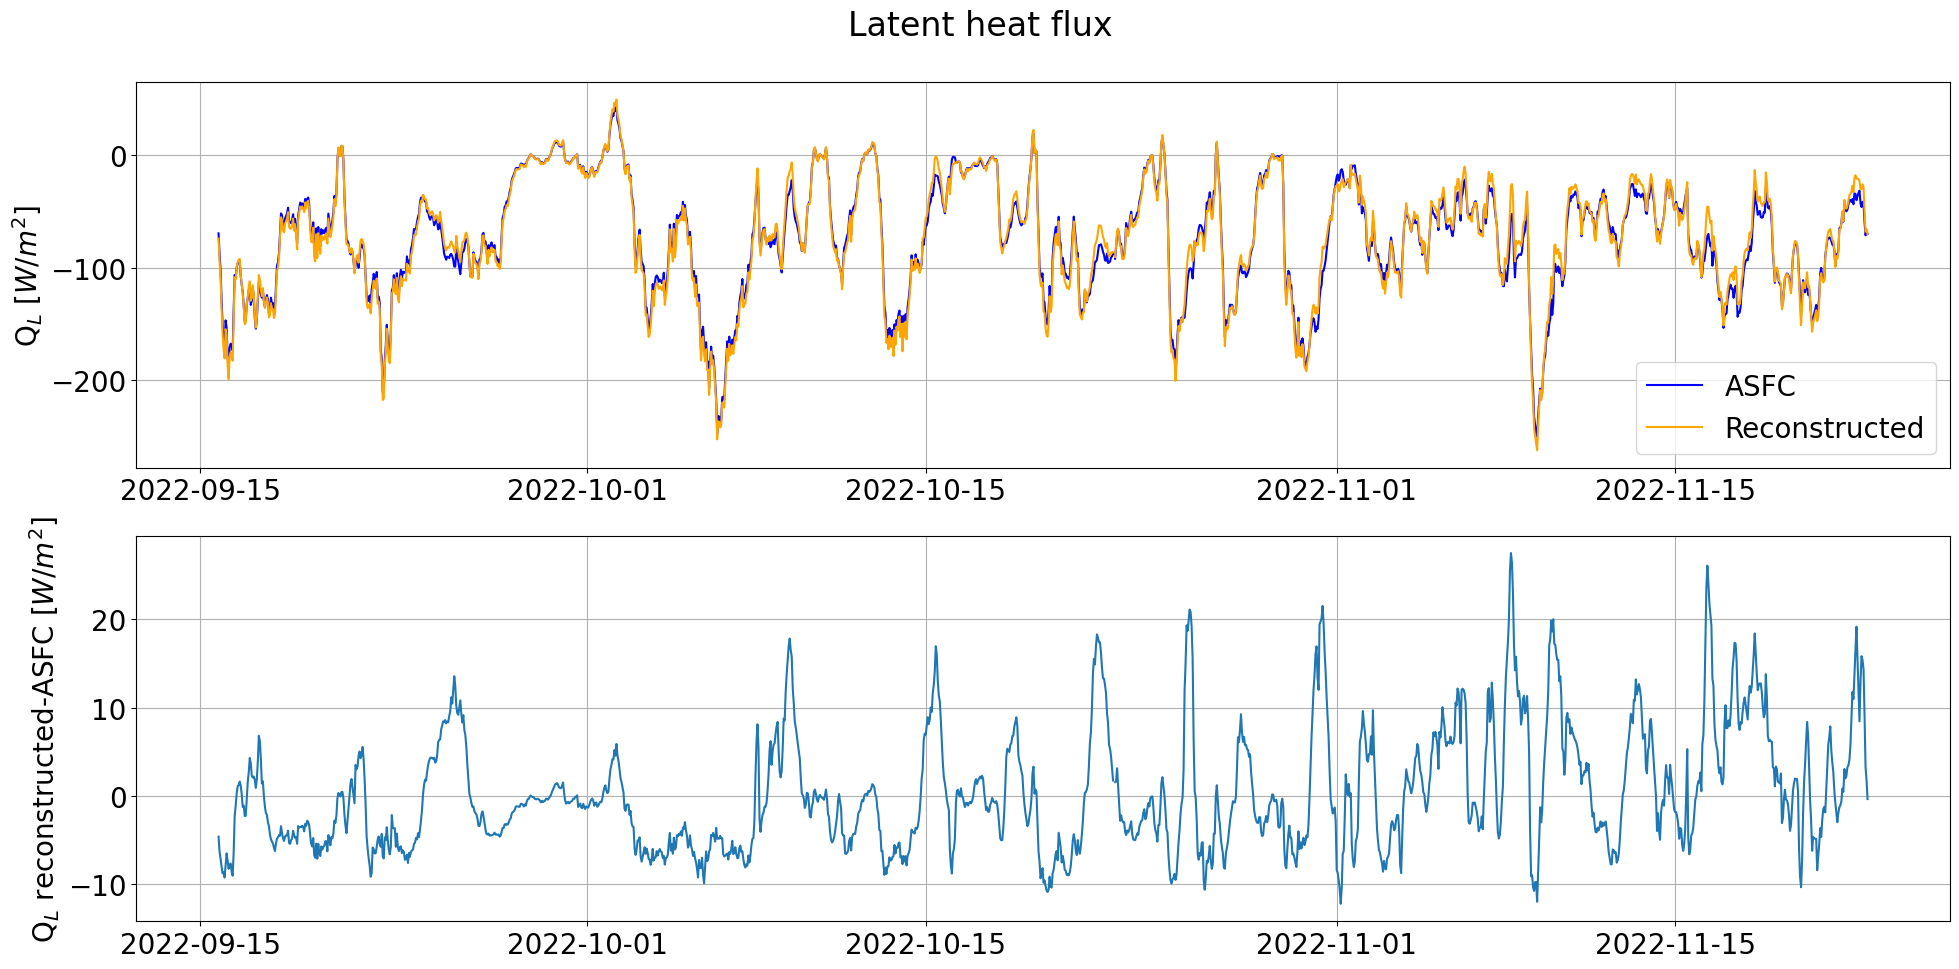

In [8]:
fig,ax = plt.subplots(2,1, figsize=(20,10))

ax[0].plot(dsadcpH.time, ASFC['latent'],'blue',label='ASFC')
ax[0].plot(dsadcpH.time,lhf_recomposed,'orange',label='Reconstructed')
ax[0].legend()
ax[0].set_ylabel('Q$_L$ $[W/m^2]$')
ax[0].grid()

ax[1].plot(dsadcpH.time,lhf_recomposed-ASFC['latent'])
ax[1].set_ylabel('Q$_L$ reconstructed-ASFC $[W/m^2]$')
ax[1].grid()

plt.suptitle('Latent heat flux')
plt.tight_layout()
#plt.savefig('Figures/15-Reynolds_decomposition/latent_hf_recomposed')

plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/figures/recEQ1L.png')

In [9]:
idx_max = (lhf_recomposed-ASFC['latent']).argmax()
print((lhf_recomposed-ASFC['latent'])[idx_max])
print(lhf_recomposed[idx_max])
print(ASFC['latent'][idx_max])
print(np.abs((lhf_recomposed-ASFC['latent'])).mean())

27.51417711005613
-27.198992467375064
-54.713169577431195
5.2316724055512145


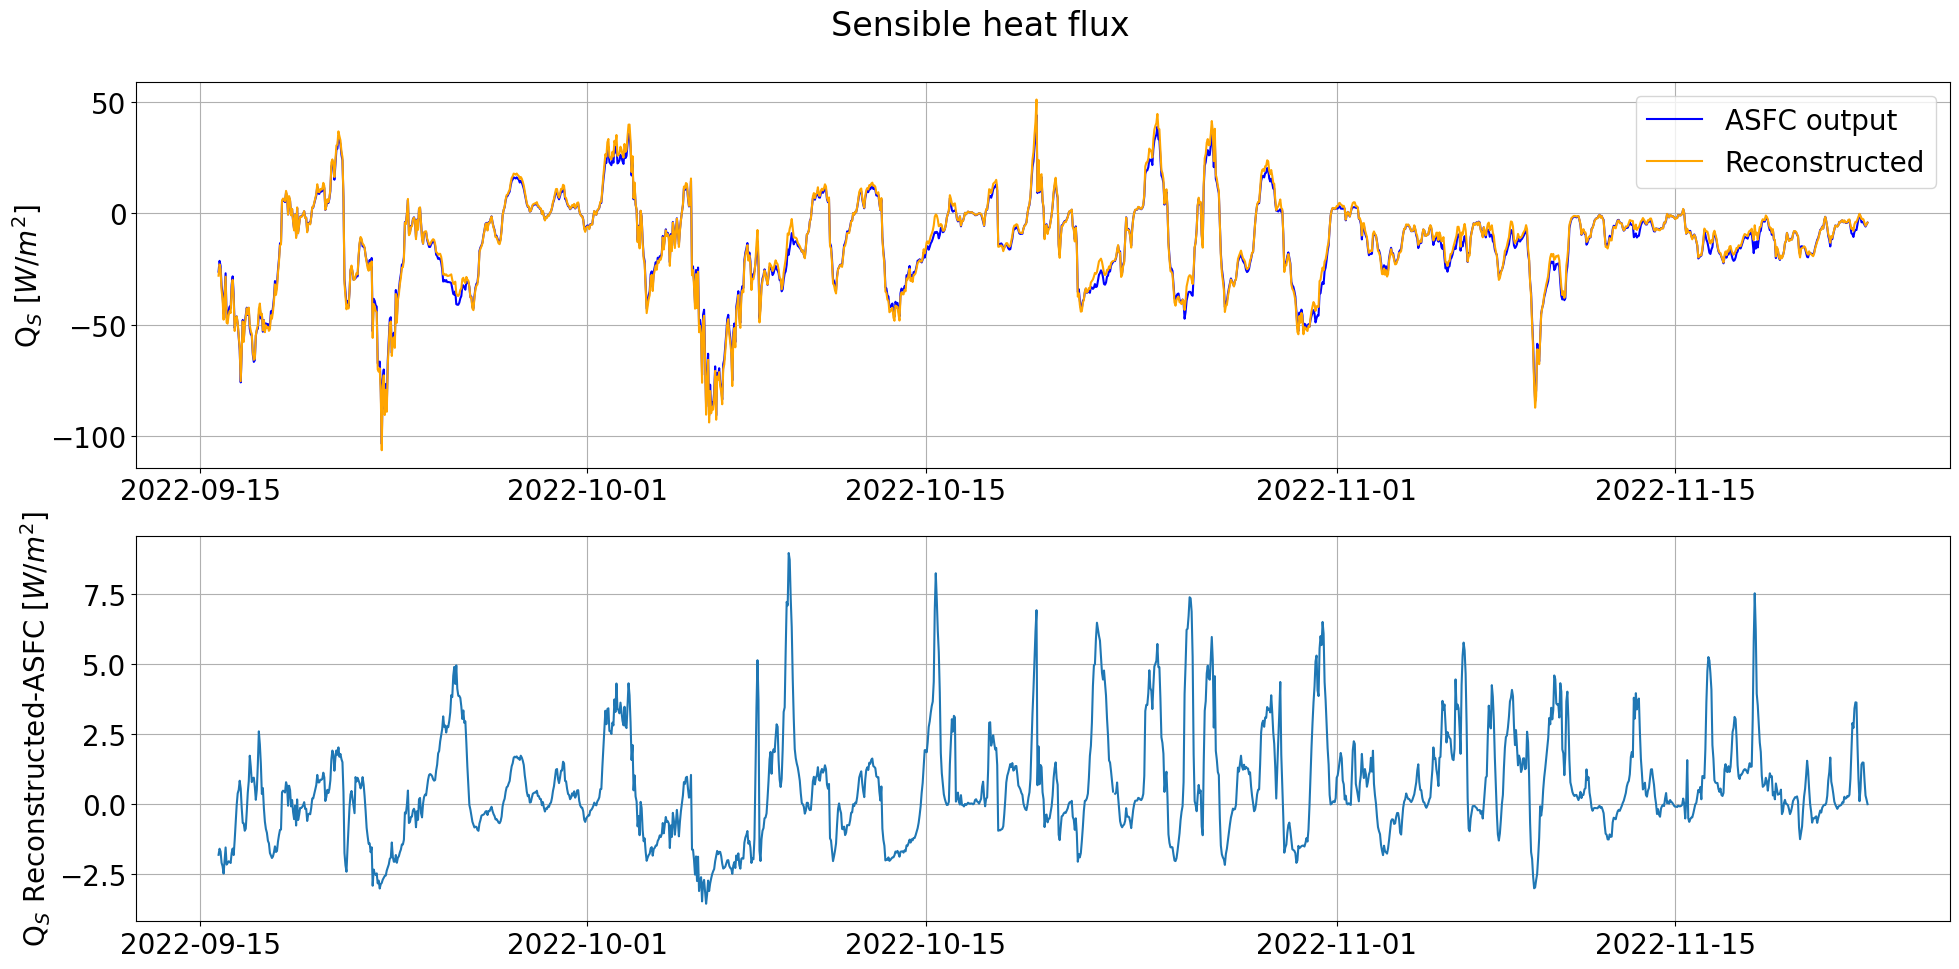

In [10]:
fig,ax = plt.subplots(2,1, figsize=(20,10))

ax[0].plot(dsadcpH.time ,ASFC['sensible'],'blue',label='ASFC output')
ax[0].plot(dsadcpH.time ,shf_recomposed,'orange',label='Reconstructed')
ax[0].legend()
ax[0].set_ylabel('Q$_S$ $[W/m^2]$')
ax[0].grid()

ax[1].plot(dsadcpH.time ,shf_recomposed-ASFC['sensible'])
ax[1].set_ylabel('Q$_S$ Reconstructed-ASFC $[W/m^2]$')
ax[1].grid()

plt.suptitle('Sensible heat flux')
plt.tight_layout()
#plt.savefig('Figures/15-Reynolds_decomposition/sensible_hf_recomposed')

plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/figures/recEQ1S.png')

In [11]:
idx_max = (shf_recomposed-ASFC['sensible']).argmax()
print((shf_recomposed-ASFC['sensible'])[idx_max])
print(shf_recomposed[idx_max])
print(ASFC['sensible'][idx_max])
print(np.abs((shf_recomposed-ASFC['sensible'])).mean())

8.97761329249645
-9.712242808482827
-18.689856100979277
1.4032300223962544


## Define coefficients

In [12]:
ct_mean = np.mean(ct)
cq_mean = np.mean(cq)
rho_mean = np.mean(rho)
cp_mean = np.mean(cp)
lv_mean = np.mean(lv)

In [13]:
ct_fluc= ct - ct_mean
cq_fluc= cq - cq_mean
rho_fluc = rho - rho_mean
cp_fluc = cp - cp_mean 
lv_fluc = lv - lv_mean 

## Check which parameters are negliable

- Cayan 1992 - "For simplicity, contributions by monthly anomalies in the exchange coefficient are not contained in (9), because these are typically only 5% of their mean values, but they are included in Table 4."
- Alexander 1997 - "The full value of $\rho$ ($\rho = \bar \rho + \rho'$) is used in (3); however, air density anomalies contribute little to Q'sh as $\rho '<< \bar \rho$ . "

Cayan 1992

In [14]:
print('In average, u-anomaly is ', round(100*np.mean(abs(u_fluc/u_mean)),2), '% of its mean value')
print('In average, t-anomaly is ', round(100*np.mean(abs(t_fluc/t_mean)),2), '% of its mean value')
print('In average, q-anomaly is ', round(100*np.mean(abs(q_fluc/q_mean)),2), '% of its mean value')
print('In average, ct-anomaly is ', round(100*np.mean(abs(ct_fluc/ct_mean)),2), '% of its mean value')
print('In average, cq-anomaly is ', round(100*np.mean(abs(cq_fluc/cq_mean)),2), '% of its mean value')
print('In average, rho-anomaly is ', round(100*np.mean(abs(rho_fluc/rho_mean)),2), '% of its mean value')
print('In average, lv-anomaly is ', round(100*np.mean(abs(lv_fluc/lv_mean)),2), '% of its mean value')
print('In average, cp-anomaly is ', round(100*np.mean(abs(cp_fluc/cp_mean)),2), '% of its mean value')

In average, u-anomaly is  43.61 % of its mean value
In average, t-anomaly is  99.71 % of its mean value
In average, q-anomaly is  48.46 % of its mean value
In average, ct-anomaly is  10.2 % of its mean value
In average, cq-anomaly is  10.2 % of its mean value
In average, rho-anomaly is  1.31 % of its mean value
In average, lv-anomaly is  0.32 % of its mean value
In average, cp-anomaly is  0.0 % of its mean value


Alexander 1997

In [15]:
threshold = 0.01
print('With a threshold equal to: ',str(threshold))
print('--------')
print('Percentage of negligible values for u: ', round(100*len(np.where(abs(u_fluc/u_mean) < threshold)[0])/len(u_fluc),2),'%')
print('Percentage of negligible values for q: ',round(100*len(np.where(abs(q_fluc/q_mean) < threshold)[0])/len(q_fluc),2),'%')
print('Percentage of negligible values for t: ',round(100*len(np.where(abs(t_fluc/t_mean) < threshold)[0])/len(t_fluc),2),'%')
print('Percentage of negligible values for cq: ',round(100*len(np.where(abs(cq_fluc/cq_mean) < threshold)[0])/len(cq_fluc),2),'%')
print('Percentage of negligible values for ct: ',round(100*len(np.where(abs(ct_fluc/ct_mean) <threshold)[0])/len(ct_fluc),2),'%')
print('Percentage of negligible values for lv: ',round(100*len(np.where(abs(lv_fluc/lv_mean) < threshold)[0])/len(lv_fluc),2),'%')
print('Percentage of negligible values for cp: ',round(100*len(np.where(abs(cp_fluc/cp_mean) <threshold)[0])/len(cp_fluc),2),'%')
print('Percentage of negligible values for rho: ',round(100*len(np.where(abs(rho_fluc/rho_mean) < threshold)[0])/len(rho_fluc),2),'%')

With a threshold equal to:  0.01
--------
Percentage of negligible values for u:  1.1 %
Percentage of negligible values for q:  1.59 %
Percentage of negligible values for t:  0.61 %
Percentage of negligible values for cq:  4.09 %
Percentage of negligible values for ct:  4.09 %
Percentage of negligible values for lv:  100.0 %
Percentage of negligible values for cp:  100.0 %
Percentage of negligible values for rho:  36.69 %


In [16]:
threshold = 0.05
print('With a threshold equal to: ',str(threshold))
print('--------')
print('Percentage of negligible values for u: ', round(100*len(np.where(abs(u_fluc/u_mean) < threshold)[0])/len(u_fluc),2),'%')
print('Percentage of negligible values for q: ',round(100*len(np.where(abs(q_fluc/q_mean) < threshold)[0])/len(q_fluc),2),'%')
print('Percentage of negligible values for t: ',round(100*len(np.where(abs(t_fluc/t_mean) < threshold)[0])/len(t_fluc),2),'%')
print('Percentage of negligible values for cq: ',round(100*len(np.where(abs(cq_fluc/cq_mean) < threshold)[0])/len(cq_fluc),2),'%')
print('Percentage of negligible values for ct: ',round(100*len(np.where(abs(ct_fluc/ct_mean) <threshold)[0])/len(ct_fluc),2),'%')
print('Percentage of negligible values for lv: ',round(100*len(np.where(abs(lv_fluc/lv_mean) < threshold)[0])/len(lv_fluc),2),'%')
print('Percentage of negligible values for cp: ',round(100*len(np.where(abs(cp_fluc/cp_mean) <threshold)[0])/len(cp_fluc),2),'%')
print('Percentage of negligible values for rho: ',round(100*len(np.where(abs(rho_fluc/rho_mean) < threshold)[0])/len(rho_fluc),2),'%')

With a threshold equal to:  0.05
--------
Percentage of negligible values for u:  5.62 %
Percentage of negligible values for q:  6.9 %
Percentage of negligible values for t:  2.63 %
Percentage of negligible values for cq:  27.9 %
Percentage of negligible values for ct:  27.9 %
Percentage of negligible values for lv:  100.0 %
Percentage of negligible values for cp:  100.0 %
Percentage of negligible values for rho:  100.0 %


# If ct and cq are non negliable:

ct and cq non negliable

In [17]:
t_term = ct_mean*u_mean*t_fluc
u_term_shf = ct_mean*t_mean*u_fluc
ct_term = ct_fluc*u_mean*t_mean
t_u_term = ct_mean*(u_fluc*t_fluc - np.mean(u_fluc*t_fluc))
t_ct_term = u_mean*(t_fluc*ct_fluc - np.mean(t_fluc*ct_fluc))
u_ct_term = t_mean*(u_fluc*ct_fluc - np.mean(u_fluc*ct_fluc))
cov_term_shf = u_fluc*ct_fluc*t_fluc - np.mean(u_fluc*ct_fluc*t_fluc)

In [18]:
q_term = cq_mean*u_mean*q_fluc
u_term_lhf = cq_mean*q_mean*u_fluc
cq_term = cq_fluc*u_mean*q_mean
q_u_term = cq_mean*(u_fluc*q_fluc - np.mean(u_fluc*q_fluc))
q_cq_term = u_mean*(q_fluc*cq_fluc - np.mean(q_fluc*cq_fluc))
u_cq_term = q_mean*(u_fluc*cq_fluc - np.mean(u_fluc*cq_fluc))
cov_term_lhf = u_fluc*cq_fluc*q_fluc - np.mean(u_fluc*cq_fluc*q_fluc)

In [19]:
shf_fluc = rho_mean*cp_mean*(t_term + u_term_shf + ct_term + t_u_term + t_ct_term + u_ct_term + cov_term_shf) 
lhf_fluc = rho_mean*lv_mean*(q_term + u_term_lhf + cq_term + q_u_term + q_cq_term + u_cq_term + cov_term_lhf) 

In [20]:
lhf_mean = np.zeros(len(q))+np.nanmean(q*u*cq)*rho_mean*lv_mean#np.mean(ASFC['latent'])
shf_mean = np.zeros(len(q))+np.nanmean(t*u*ct)*rho_mean*cp_mean#np.mean(ASFC['sensible'])


In [21]:
shf_recomposed = shf_mean + shf_fluc
lhf_recomposed = lhf_mean + lhf_fluc

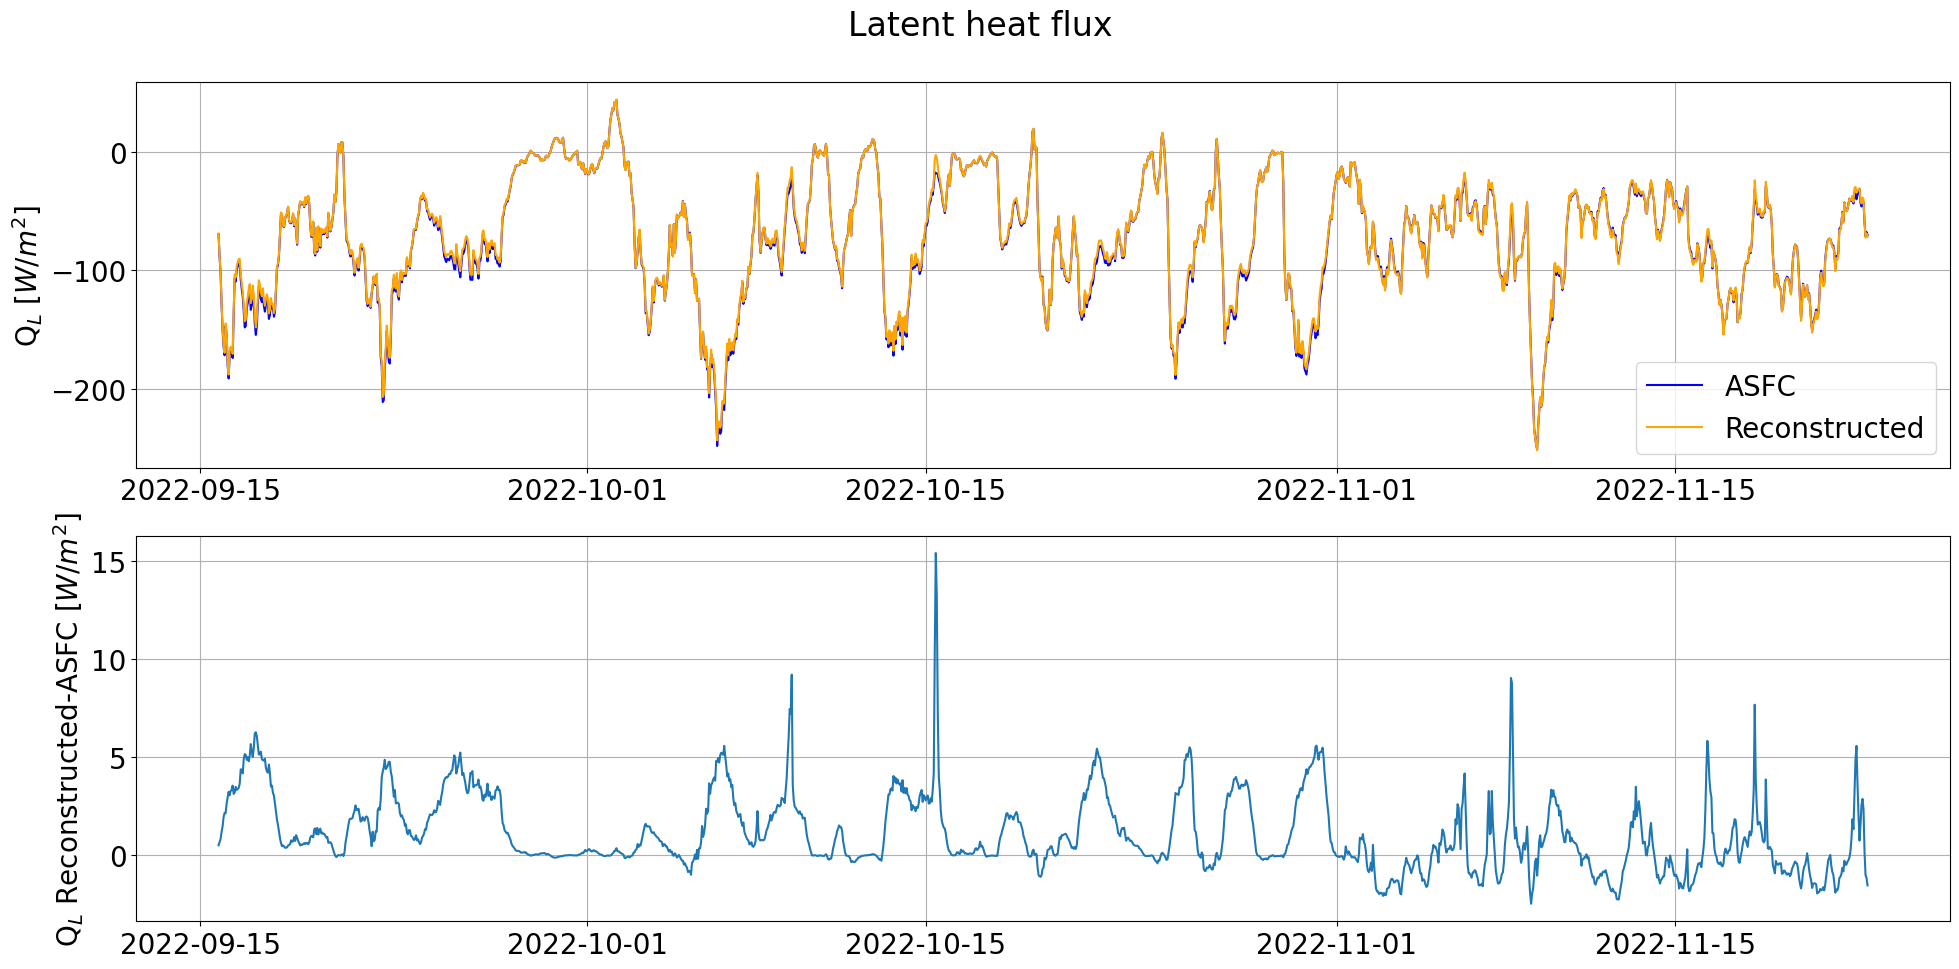

In [22]:
fig,ax = plt.subplots(2,1, figsize=(20,10))

ax[0].plot(dsadcpH.time,ASFC['latent'],'blue',label='ASFC')
ax[0].plot(dsadcpH.time,lhf_recomposed,'orange',label='Reconstructed')
ax[0].legend()
ax[0].set_ylabel('Q$_L$ $[W/m^2]$')
ax[0].grid()

ax[1].plot(dsadcpH.time,lhf_recomposed-ASFC['latent'])
ax[1].set_ylabel('Q$_L$ Reconstructed-ASFC $[W/m^2]$')
ax[1].grid()

plt.suptitle('Latent heat flux')
plt.tight_layout()
#plt.savefig('Figures/15-Reynolds_decomposition/latent_hf_recomposed_final')


plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/figures/recEQ2L.png')

In [23]:
idx_max = (lhf_recomposed-ASFC['latent']).argmax()
print((lhf_recomposed-ASFC['latent'])[idx_max])
print(lhf_recomposed[idx_max])
print(ASFC['latent'][idx_max])
print(np.abs((lhf_recomposed-ASFC['latent'])).mean())

15.41177398211953
-2.798912303588679
-18.21068628570821
1.497498962722273


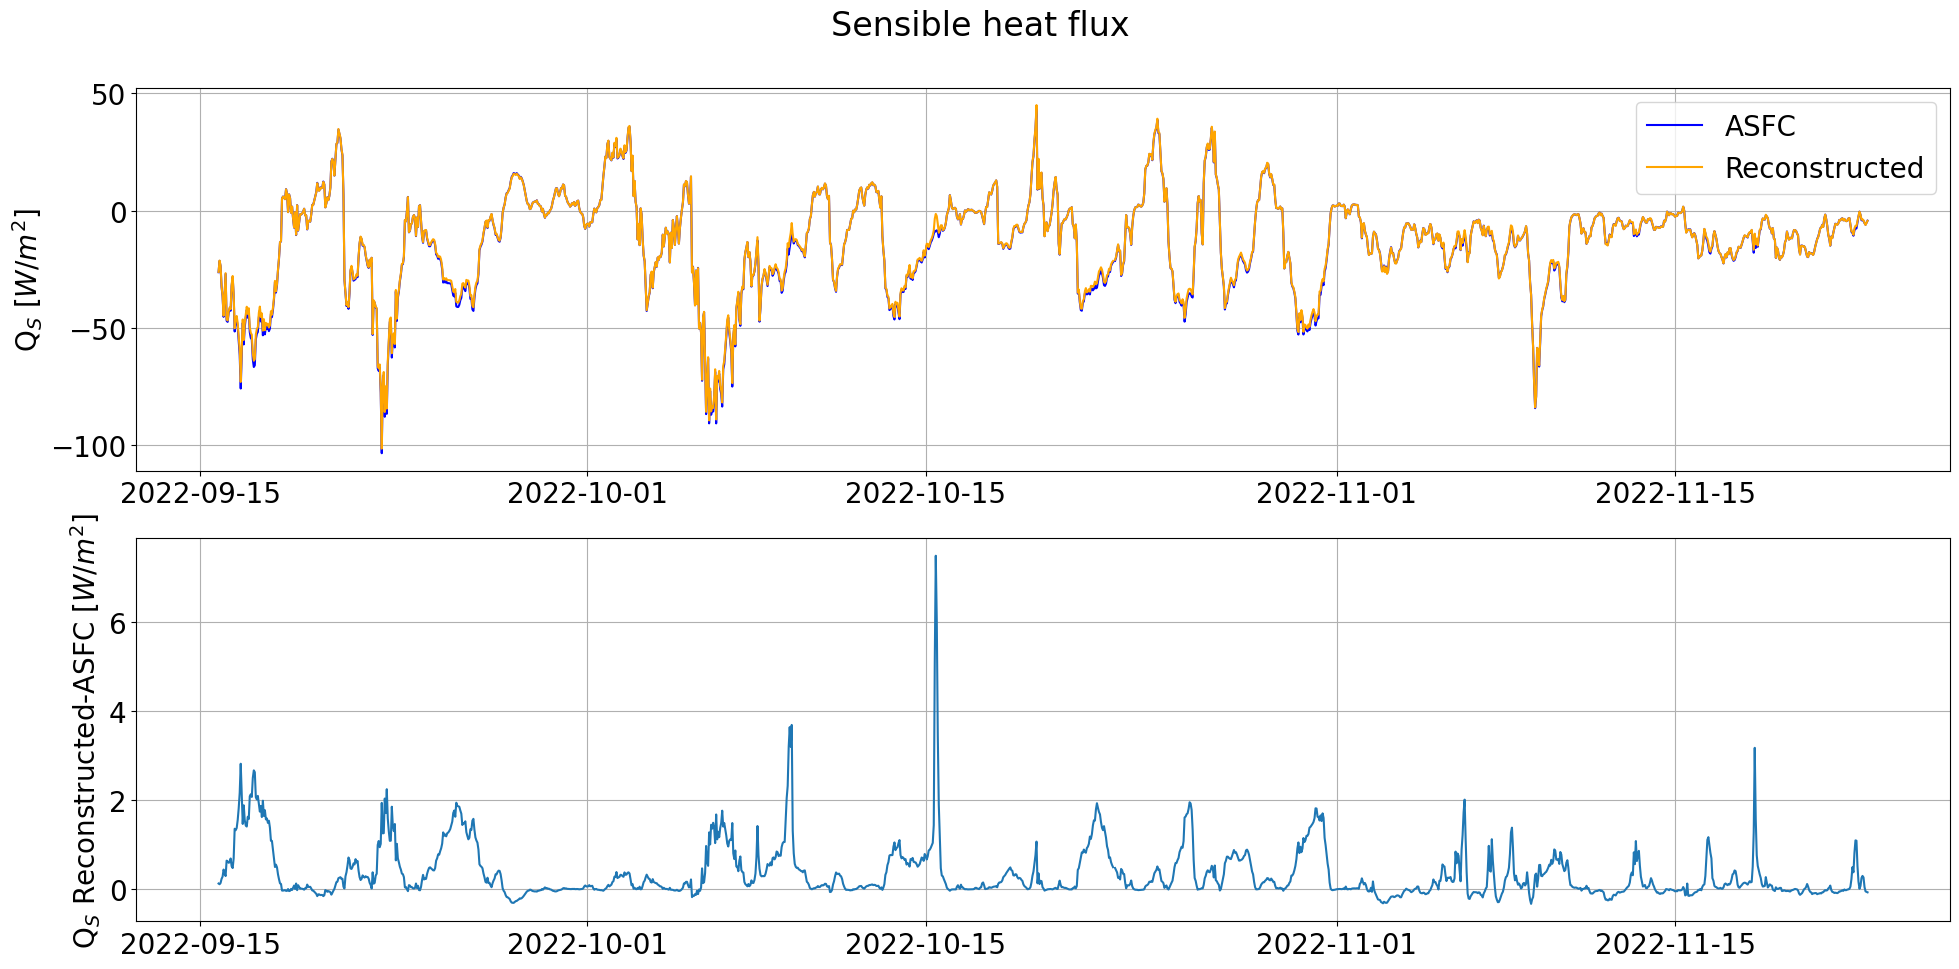

In [24]:
fig,ax = plt.subplots(2,1, figsize=(20,10))

ax[0].plot(dsadcpH.time, ASFC['sensible'],'blue',label='ASFC')
ax[0].plot(dsadcpH.time,shf_recomposed,'orange',label='Reconstructed')
ax[0].legend()
ax[0].set_ylabel('Q$_S$ $[W/m^2]$')
ax[0].grid()

ax[1].plot(dsadcpH.time, shf_recomposed-ASFC['sensible'])
ax[1].set_ylabel('Q$_S$ Reconstructed-ASFC $[W/m^2]$')
ax[1].grid()

plt.suptitle('Sensible heat flux')
plt.tight_layout()
#plt.savefig('Figures/15-Reynolds_decomposition/sensible_hf_recomposed_final')

plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/figures/recEQ2S.png')

In [25]:
idx_max = (shf_recomposed-ASFC['sensible']).argmax()
print((shf_recomposed-ASFC['sensible'])[idx_max])
print(shf_recomposed[idx_max])
print(ASFC['sensible'][idx_max])
print(np.abs((shf_recomposed-ASFC['sensible'])).mean())

7.494650008578203
-1.3645422127842082
-8.859192221362411
0.3918168447756485


# Histogram, absolute values of fluctuations?

In [26]:
#shf_fluc = rho*cp*(t_term + u_term_shf + ct_term + t_u_term + t_ct_term + u_ct_term + cov_term_shf) 
#lhf_fluc = rho*lv*(q_term + u_term_lhf + cq_term + q_u_term + q_cq_term + u_cq_term + cov_term_lhf) 

In [27]:
mag_shf_fluc = rho_mean*cp_mean*(np.abs(t_term) + np.abs(u_term_shf) + np.abs(ct_term) + np.abs(t_u_term) + np.abs(t_ct_term) + np.abs(u_ct_term) + np.abs(cov_term_shf)) 
mag_lhf_fluc = rho_mean*lv_mean*(np.abs(q_term) + np.abs(u_term_lhf) + np.abs(cq_term) + np.abs(q_u_term) + np.abs(q_cq_term) + np.abs(u_cq_term) + np.abs(cov_term_lhf)) 

In [28]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [29]:
from datetime import datetime, timedelta

In [30]:
shf_terms=[mag_shf_fluc, t_term, u_term_shf, ct_term, t_u_term, t_ct_term, u_ct_term, cov_term_shf]
lhf_terms=[mag_lhf_fluc, q_term, u_term_lhf, cq_term, q_u_term, q_cq_term, u_cq_term, cov_term_lhf]

label_shf_terms=['mag_shf_fluc', 't_term', 'u_term_shf', 'ct_term', 't_u_term', 't_ct_term', 'u_ct_term', 'cov_term_shf']
label_lhf_terms=['mag_lhf_fluc', 'q_term', 'u_term_lhf', 'cq_term', 'q_u_term', 'q_cq_term', 'u_cq_term', 'cov_term_lhf']

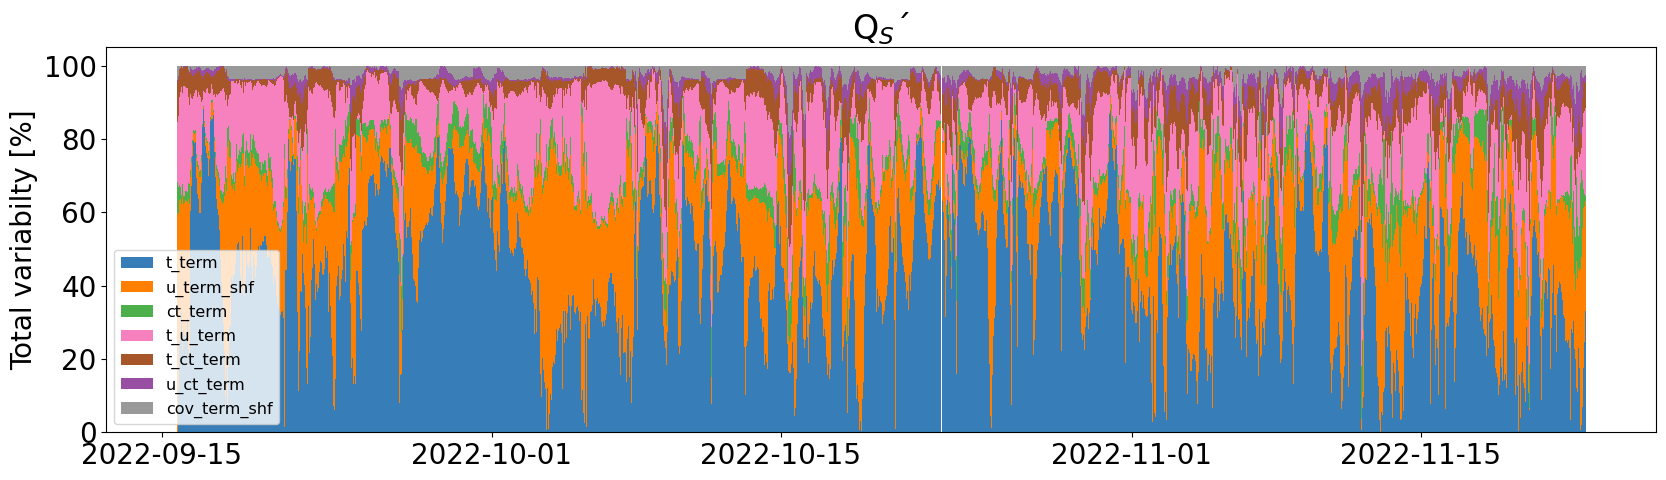

In [31]:
fig,ax = plt.subplots(figsize=(20,5))


#y1=rho*lv*np.abs(q_term)/mag_lhf_fluc
#y2=rho*lv*np.abs(u_term_lhf)/mag_lhf_fluc
for t in np.arange(len(dsadcpH.time)-1):
    y1_list=[]
    for i in np.arange(1,8):
        y1=rho_mean*cp_mean*np.abs(shf_terms[i][t])/shf_terms[0][t]*100
        
        ax.bar(dsadcpH.time[t], y1, bottom=np.sum(y1_list), color=CB_color_cycle[i-1],width=pd.Timedelta(hours=1))
        y1_list.append(y1)
        
y1_list=[]        
for i in np.arange(1,8):
        y1=(rho_mean*cp_mean*np.abs(shf_terms[i][len(dsadcpH.time)-1])/shf_terms[0][len(dsadcpH.time)-1])*100
        
        ax.bar(dsadcpH.time[len(dsadcpH.time)-1], y1, bottom=np.sum(y1_list), color=CB_color_cycle[i-1],width=pd.Timedelta(hours=1), label=label_shf_terms[i])
        y1_list.append(y1)        
        
        
ax.legend(fontsize='xx-small')
ax.set_ylabel('Total variabilty [%]')
ax.set_title('Q$_S$´')

plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/figures/barstackS.png')

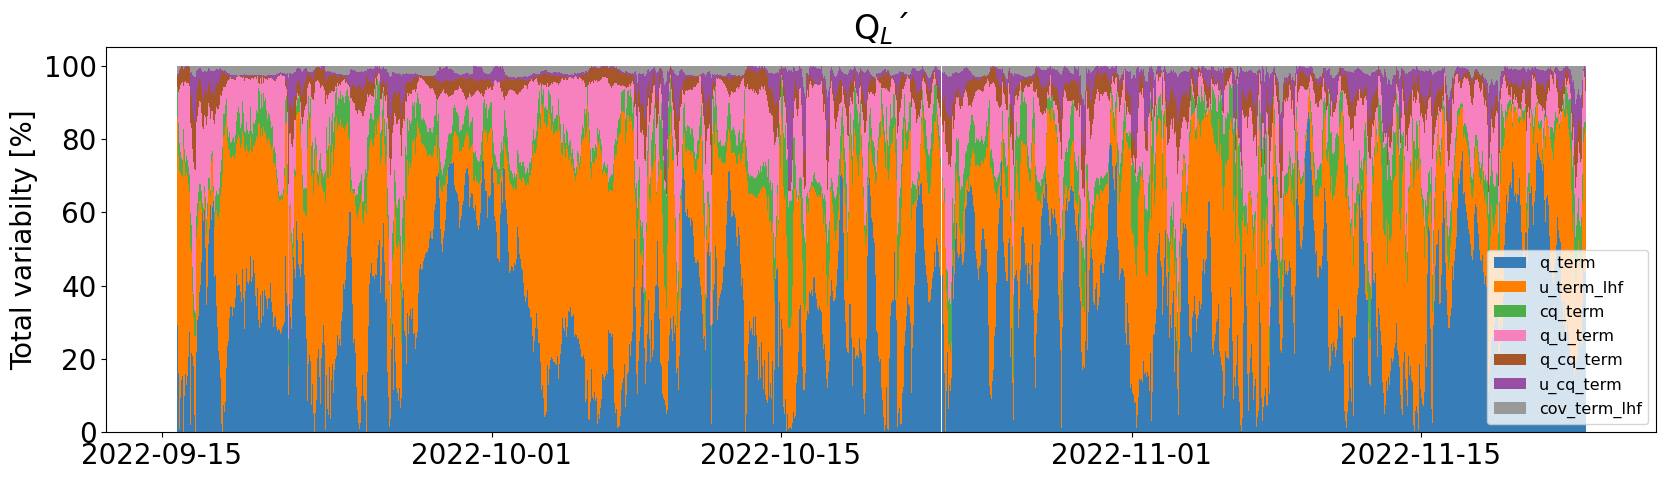

In [32]:
fig,ax = plt.subplots(figsize=(20,5))


#y1=rho*lv*np.abs(q_term)/mag_lhf_fluc
#y2=rho*lv*np.abs(u_term_lhf)/mag_lhf_fluc
for t in np.arange(len(dsadcpH.time)-1):
    y1_list=[]
    for i in np.arange(1,8):
        y1=rho_mean*lv_mean*np.abs(lhf_terms[i][t])/lhf_terms[0][t]*100
        
        ax.bar(dsadcpH.time[t], y1, bottom=np.sum(y1_list), color=CB_color_cycle[i-1], width=pd.Timedelta(hours=1))
        y1_list.append(y1)
        
        
y1_list=[]        
for i in np.arange(1,8):
        y1=rho_mean*lv_mean*np.abs(lhf_terms[i][len(dsadcpH.time)-1])/lhf_terms[0][len(dsadcpH.time)-1]*100
        
        ax.bar(dsadcpH.time[len(dsadcpH.time)-1], y1, bottom=np.sum(y1_list), color=CB_color_cycle[i-1], width=pd.Timedelta(hours=1), label=label_lhf_terms[i])
        y1_list.append(y1)        
        
        
ax.legend(fontsize='xx-small')

ax.set_ylabel('Total variabilty [%]')
ax.set_title('Q$_L$´')

plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/figures/barstackL.png')